
# 📚 Introduction   
Ce notebook présente une preuve de concept (proof of concept) pour un système de classification binaire de radios thoraciques visant à détecter des cas de pneumonie. Le modèle repose sur le transfert d’apprentissage (transfer learning) à partir de réseaux de neurones convolutifs (CNN) préentraînés, adaptés à la tâche de classification médicale



# 1️⃣ Import des librairies 


In [1]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import mlflow
import matplotlib.pyplot as plt
import mlflow.tensorflow




# 2️⃣ Préparation et exploration de données


In [2]:

train_dir = 'data/chest_xray/train'
val_dir = 'data/chest_xray/test'
test_dir = 'data/chest_xray/val'

img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


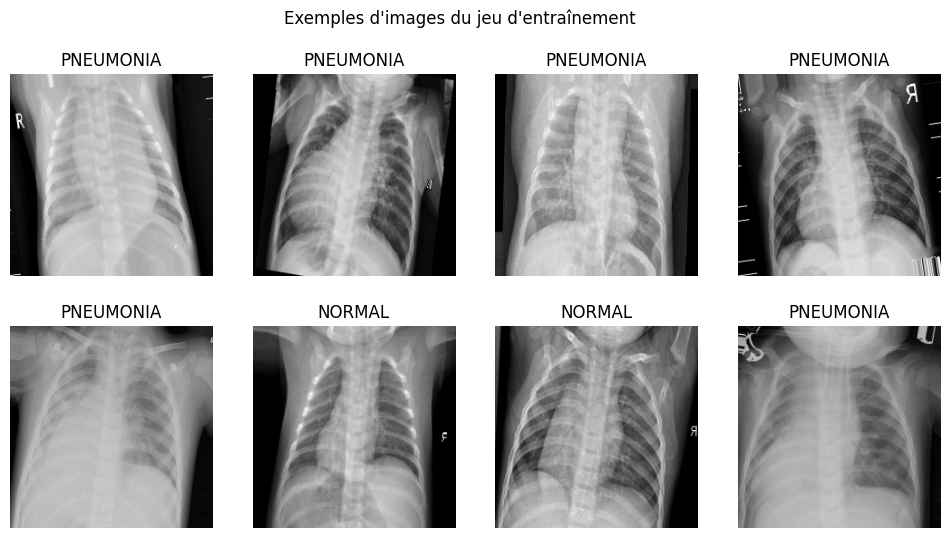

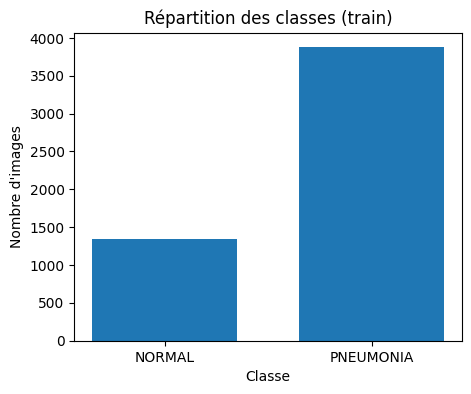

In [3]:
# Affichage de quelques images du jeu d'entraînement avec leur label
class_names = list(train_generator.class_indices.keys())
images, labels = next(train_generator)

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[int(labels[i])])
    plt.axis('off')
plt.suptitle("Exemples d'images du jeu d'entraînement")
plt.show()

# Répartition des classes dans le jeu d'entraînement
counts = train_generator.classes
plt.figure(figsize=(5, 4))
plt.hist(counts, bins=np.arange(len(class_names)+1)-0.5, rwidth=0.7)
plt.xticks(range(len(class_names)), class_names)
plt.title("Répartition des classes (train)")
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.show()


# 3️⃣ Construction du modèle VGG16 avec transfert d’apprentissage


In [4]:


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # On gèle les couches du modèle pré-entraîné

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)


# 4️⃣ Entraînement du modèle avec MLflow


In [5]:
# End any previously active MLflow run
# mlflow.end_run()

mlflow.set_experiment("pneumonia_vgg16_transfer_learning")

with mlflow.start_run():
    mlflow.tensorflow.autolog()
    history = model.fit(
        train_generator,
        epochs=5,
        validation_data=val_generator
    )


2025/05/28 15:31:54 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2025/05/28 15:31:54 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
c:\Users\adjah\Desktop\CNN\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6468 - loss: 0.6433

163/163 ━━━━━━━━━━━━━━━━━━━━ 860s 5s/step - accuracy: 0.6471 - loss: 0.6430 - val_accuracy: 0.6250 - val_loss: 0.6068
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7604 - loss: 0.4999

163/163 ━━━━━━━━━━━━━━━━━━━━ 946s 6s/step - accuracy: 0.7604 - loss: 0.4998 - val_accuracy: 0.6394 - val_loss: 0.5476
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8024 - loss: 0.4221

163/163 ━━━━━━━━━━━━━━━━━━━━ 1045s 6s/step - accuracy: 0.8025 - loss: 0.4220 - val_accuracy: 0.6699 - val_loss: 0.5187
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8390 - loss: 0.3613

163/163 ━━━━━━━━━━━━━━━━━━━━ 818s 5s/step - accuracy: 0.8391 - loss: 0.3613 - val_accuracy: 0.7452 - val_loss: 0.4694
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8573 - loss: 0.3314

163/163 ━━━━━━━━━━━━━━━━━━━━ 877s 5s/step - accuracy: 0.8574 - loss: 0.3313 - val_accuracy: 0.7660 - val_loss: 0.4527


2025/05/28 16:47:42 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2025/05/28 16:47:42 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/05/28 16:48:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



# 5️⃣ Évaluation du modèle


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5625 - loss: 0.6648
Test Loss: 0.6648, Test Accuracy: 0.5625


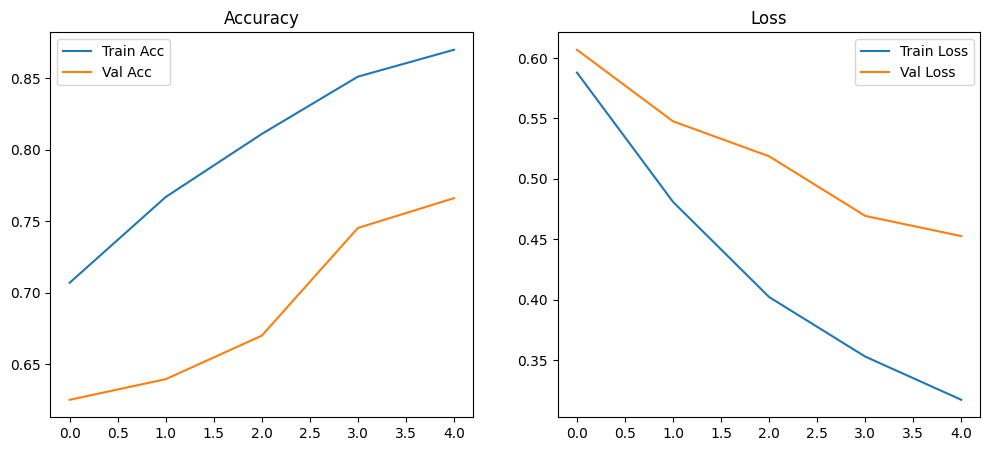

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


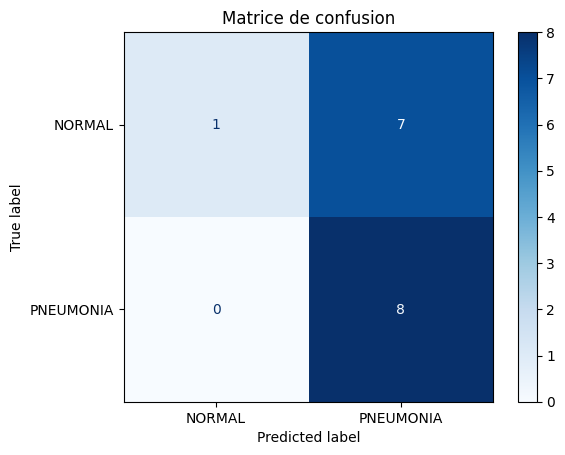

In [6]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Affichage des courbes d'apprentissage
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Prédictions sur le jeu de test
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.show()

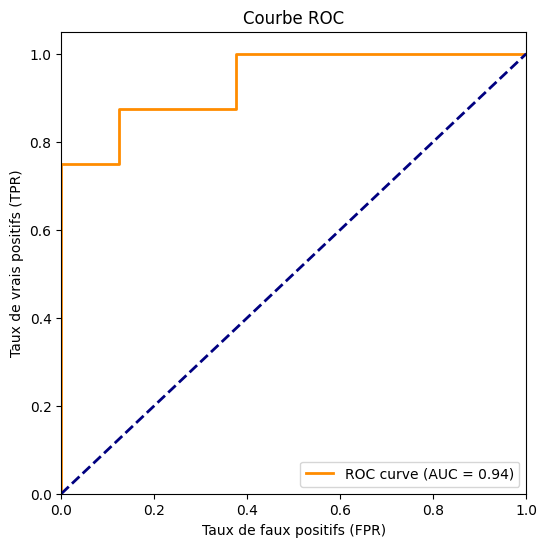

In [8]:
from sklearn.metrics import roc_curve, auc

# Calcul de la courbe ROC et de l'AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

Les courbes affichées précédemment permettent d'évaluer les performances du modèle :

- **Courbes d'apprentissage (accuracy et loss)** :  
    La courbe d'accuracy montre l'évolution de la précision sur les ensembles d'entraînement et de validation au fil des époques. Un écart important entre les deux peut indiquer un surapprentissage (overfitting). La courbe de loss permet de vérifier si la fonction de coût diminue correctement et si le modèle converge.

- **Courbe ROC (Receiver Operating Characteristic)** :  
    Elle illustre la capacité du modèle à distinguer entre les deux classes (pneumonie vs normal) pour différents seuils de classification. Plus la courbe est proche du coin supérieur gauche, meilleure est la performance. L'aire sous la courbe (AUC) quantifie cette performance : une valeur proche de 1 indique un excellent modèle, tandis qu'une valeur proche de 0,5 correspond à un modèle aléatoire.

Ces visualisations sont essentielles pour diagnostiquer la qualité de l'apprentissage, détecter d'éventuels problèmes de surapprentissage et évaluer la capacité de généralisation du modèle.


# 6️⃣ Sauvegarde et traçabilité du modèle


In [7]:


model.save('vgg16_pneumonia_classifier.h5')
mlflow.log_artifact('vgg16_pneumonia_classifier.h5')



# 7️⃣ Conclusion et perspectives
Le modèle VGG16 a été utilisé comme point de départ académique pour explorer le concept de transfert learning appliqué à la détection de la pneumonie à partir de radios thoraciques.

✅ Avantages de VGG16 :   
* Simplicité et clarté de l’architecture : VGG16 est largement documenté, bien connu dans la communauté, et constitue un excellent point d’entrée pour apprendre les bases du transfert learning.

* Rapidité d’implémentation : grâce à sa structure simple, il est facile à adapter à des tâches de classification binaire avec peu de modifications.

* Résultats corrects en apprentissage gelé : malgré l'absence de dégel, le modèle parvient à atteindre des performances intéressantes, notamment une bonne capacité à détecter les cas de pneumonie (rappel élevé).

⚠️ Limites observées :   
* Overfitting visible : le modèle apprend bien sur l'ensemble d'entraînement mais a du mal à généraliser sur la validation, ce qui est confirmé par l’écart entre la précision entraînement/validation et la val_loss instable.

* Manque de finesse dans la détection des cas normaux : la matrice de confusion montre une forte sensibilité mais une précision réduite sur la classe "NORMAL", ce qui peut poser problème en contexte clinique.

* Aucune couche décongelée : sans dégel partiel, le modèle reste limité à des représentations génériques, initialement conçues pour des images naturelles (ImageNet), peu adaptées à des données médicales spécifiques.


VGG16 peut jouer un rôle pédagogique dans un prototype ou une preuve de concept, mais il n’est pas optimal pour un usage médical réel, notamment en raison :

* du manque de finesse pour détecter les cas négatifs,

* de son architecture peu profonde comparée à des modèles plus récents,

* de l’absence d’ajustement fin (fine-tuning).

🔁 Perspectives
Pour répondre aux exigences d’un usage médical (robustesse, précision, sensibilité), il est préférable d’utiliser un modèle plus adapté.   
👉 Pour cette raison, la suite du projet s’est naturellement orientée vers des modèles plus performants comme DenseNet121, avec un dégel partiel des couches pour adapter finement les représentations apprises au domaine médical.